In [13]:
import pandas as pd
import altair as alt
import numpy as np
from pathlib import Path
import sys, os
  
from helpers import read
 
import bottleneck as bn
from LPA import Corpus, sockpuppet_distance
from math import floor
from scipy.spatial.distance import cdist, cityblock
import matplotlib.pyplot as plt
from visualize import sockpuppet_matrix, timeline

alt.data_transformers.disable_max_rows()
 

DataTransformerRegistry.enable('default')

In [14]:
#ccdf = pd.read_csv("/Users/hagitbenshoshan/Documents/PHD/LPA/raw_data/death_cause/np_freq/0_normalized.csv")
ccdf=pd.read_csv("data/COD/0_normalized.csv")
cc = ccdf.pivot_table(
    index="document", columns="element", values="frequency_in_document"
).to_numpy()
cdist_ = cdist(cc, cc, metric="cityblock")
cdist_[np.triu_indices(len(cdist_), k=1)] = np.nan
ccdf = pd.DataFrame(
    cdist_,
    index=ccdf["document"].drop_duplicates(),
    columns=ccdf["document"].drop_duplicates(),
)
mmdf = (
    (ccdf / ccdf.max().max())
    .rename_axis(index="year")
    .melt(ignore_index=False, var_name="year ")
    .dropna()
    .reset_index()
)
display(sockpuppet_matrix(mmdf))

alt.Chart(...)

In [15]:
 
df = pd.read_csv(f"./data/COD/0_normalized.csv")
corpus = Corpus(df)
dvr = corpus.create_dvr(equally_weighted=True)
sigs = corpus.create_signatures(distance="JSD")
# sigs[1].to_csv("results/death_cause/top_30_most_changed.csv")
# display(
#     timeline(
#         df,
#         x="document",
#         y="frequency_in_document",
#         title="Cause of death, world",
#         corpus="death_cause",
#         stack="center",
#         order=dvr["element"].tolist(),
#         name=f"1",
#     )
# )
 
spd = sockpuppet_distance(corpus, corpus, heuristic=False)
'''
display(
    sockpuppet_matrix(spd)
    .properties(title="Cause of death, world")
    .configure_axis(title=None)
)
''' 

'\ndisplay(\n    sockpuppet_matrix(spd)\n    .properties(title="Cause of death, world")\n    .configure_axis(title=None)\n)\n'

In [16]:
edf = pd.read_csv(f"data/COD/0_normalized.csv")
ecorpus = Corpus(edf)
edvr = ecorpus.create_dvr(equally_weighted=True)

esigs = ecorpus.create_signatures(distance="JSD")
espd = sockpuppet_distance(ecorpus, ecorpus, heuristic=False, distance="euclidean")
display(
    sockpuppet_matrix(spd)
    .properties(title="Cause of death, world")
    .configure_axis(title=None)
)

alt.Chart(...)

In [17]:
import altair_saver

dddd = esigs[1]
top_changing = dddd[dddd.sum(0).abs().sort_values(ascending=False).head(10).index]
chart = (
    alt.Chart(
        top_changing.reset_index()
        .melt(id_vars="index")
        .rename(
            columns={
                "index": "Year",
                "variable": "Cause of Death",
                "value": "Distance from PM",
            }
        )
    )
    .mark_line()
    .encode(x="Year:N", y="Distance from PM", color="Cause of Death")
    .properties(width=300, height=300, title="")
)
#fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=3)
chart.save("results/cod/top_10_distances.png", scale_factor=4.0)
#chart.save("final_results/top_10_distances.png", scale_factor=4.0)


In [18]:
alt.Chart(
    edf[edf["element"].isin(top_changing)].rename(
        columns={
            "document": "Year",
            "element": "Cause of Death",
            "frequency_in_document": "% of All Deaths",
        }
    )
).mark_line().encode(
    x="Year:N", y="% of All Deaths:Q", color="Cause of Death"
).properties(
    width=300, height=300
)

alt.Chart(...)

In [19]:
edf[edf["document"] == 1990].sum()

document                                                             61690
element                  Acute hepatitisAlcohol use disordersAlzheimer'...
frequency_in_document                                             0.008169
dtype: object

In [20]:
edvr

,element,global_weight
0,Cardiovascular diseases,0.303914
1,Neoplasms,0.155618
2,Chronic respiratory diseases,0.071259
3,Lower respiratory infections,0.057558
4,Neonatal disorders,0.052868
5,Diarrheal diseases,0.045749
6,Digestive diseases,0.044628
7,Tuberculosis,0.031557
8,Cirrhosis and other chronic liver diseases,0.025457
9,Road injuries,0.024763


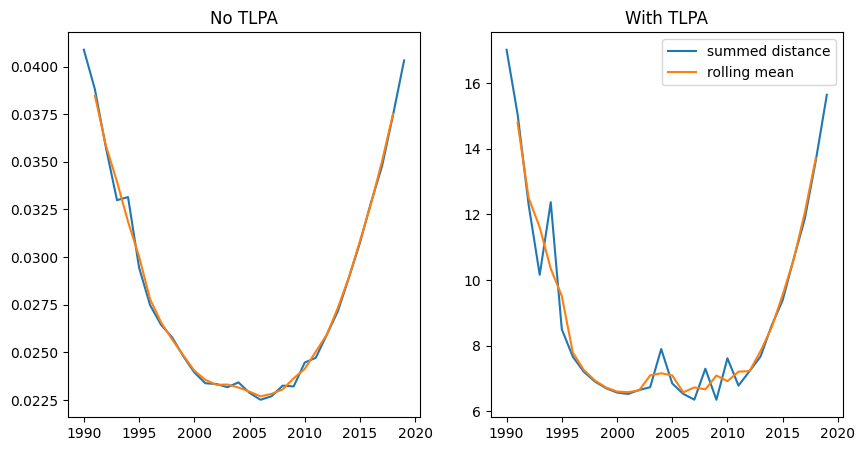

In [21]:
corr = (
    (
        spd.pivot(index="Corpus 1", columns="Corpus 2", values="value").T.fillna(0)
        + spd.pivot(index="Corpus 1", columns="Corpus 2", values="value").fillna(0)
    )
    .sum(axis=1)
    .rename_axis("Year")
)
rolling_mean = corr.rolling(3).mean().shift(-1)
normalized = corr.iloc[2:] - rolling_mean
# (corr.iloc[2:] - rolling_mean).rolling(3).var()
# rolling_mean
ccorr = (ccdf.fillna(0) + ccdf.fillna(0).T).sum(axis=1).rename_axis("Year")
# ccorr.plot()
# print(ccorr)
crolling_mean = ccorr.rolling(3).mean().shift(-1)
# print(crolling_mean)
# crolling_mean.plot()
cnormalized = ccorr - crolling_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # , sharey=True)

ax1.plot(ccorr, label="summed distance")
ax1.plot(crolling_mean, label="rolling mean")

ax1.set_title("No TLPA")

ax2.plot(corr, label="summed distance")
ax2.plot(rolling_mean, label="rolling mean")

ax2.set_title("With TLPA")
plt.legend()
plt.show()

In [22]:
v = pd.Series([1, 2, 4, 5, 32, 2, 45, 3])
display(v)
display(v.rolling(2).mean())
display(v.rolling(3).mean())

0     1
1     2
2     4
3     5
4    32
5     2
6    45
7     3
dtype: int64

0     NaN
1     1.5
2     3.0
3     4.5
4    18.5
5    17.0
6    23.5
7    24.0
dtype: float64

0          NaN
1          NaN
2     2.333333
3     3.666667
4    13.666667
5    13.000000
6    26.333333
7    16.666667
dtype: float64

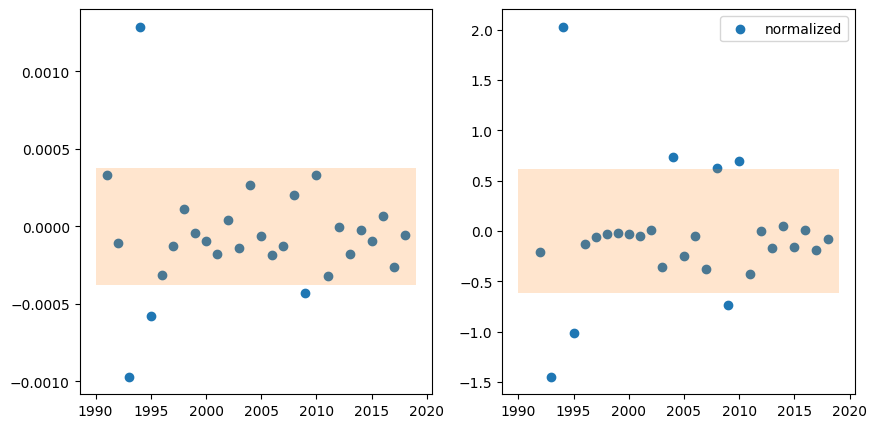

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bnormalized = cnormalized
ax1.scatter(bnormalized.index, bnormalized, label="normalized")
cstd = bnormalized.std()
# cstd = bnormalized.rolling(3).std()
ax1.fill_between(bnormalized.index, -cstd, cstd, alpha=0.2)

ax2.scatter(normalized.index, normalized, label="normalized")
std = normalized.std()
ax2.fill_between(normalized.index, -std, std, alpha=0.2)

plt.legend()
plt.show()

In [24]:
bn = (bnormalized / bnormalized.max()).reset_index().rename(columns={0: "dist"})
bn["method"] = "Without TLPA"
bn["std"] = bn["dist"].std()
bn["mstd"] = -bn["dist"].std()
cn = (normalized / normalized.max()).reset_index().rename(columns={0: "dist"})
cn["method"] = "With TLPA"
cn["std"] = cn["dist"].std()
cn["mstd"] = -cn["dist"].std()

# an = pd.concat([bn, cn])
out = "out"
for an in (bn, cn):
    chart = (
        alt.Chart(an)
        .mark_circle(color="#3d65a5")
        .encode(
            x="Year:O",
            y=alt.Y("dist", title="Normalized Summed Distance"),
        )
    )
    error_bands = (
        alt.Chart(an)
        .mark_errorband(color="#e89d92")
        .encode(
            x="Year:N", y=alt.Y("std", title="Normalized Summed Distance"), y2="mstd"
        )
    )
    rules = alt.Chart(an).mark_rule(color="#d3d3d3").encode(x="Year:O")
    display(
        (rules + error_bands + chart).properties(
            width=350, height=200, title=f"With{out} TLA"
        )
    )
    out = ""

    # .facet(alt.Facet("method", title="With and without TLPA")).configure_legend(title=None, orient='top'))

alt.LayerChart(...)

alt.LayerChart(...)

In [25]:
bn[bn["dist"].abs() > bn["std"]]

,Year,dist,method,std,mstd
3,1993,-0.753583,Without TLPA,0.29231,-0.29231
4,1994,1.000000,Without TLPA,0.29231,-0.29231
5,1995,-0.446807,Without TLPA,0.29231,-0.29231
19,2009,-0.335221,Without TLPA,0.29231,-0.29231


In [26]:
bnormalized.reset_index()

,Year,0
0,1990,NaN
1,1991,0.000329
2,1992,-0.000105
3,1993,-0.000970
4,1994,0.001288
5,1995,-0.000575
6,1996,-0.000314
7,1997,-0.000127
8,1998,0.000110
9,1999,-0.000045


In [27]:
bnormalized

Year
1990         NaN
1991    0.000329
1992   -0.000105
1993   -0.000970
1994    0.001288
1995   -0.000575
1996   -0.000314
1997   -0.000127
1998    0.000110
1999   -0.000045
2000   -0.000092
2001   -0.000178
2002    0.000044
2003   -0.000141
2004    0.000269
2005   -0.000064
2006   -0.000182
2007   -0.000124
2008    0.000200
2009   -0.000432
2010    0.000333
2011   -0.000320
2012   -0.000006
2013   -0.000177
2014   -0.000022
2015   -0.000093
2016    0.000066
2017   -0.000262
2018   -0.000053
2019         NaN
dtype: float64

In [28]:
normalized

Year
1990         NaN
1991         NaN
1992   -0.211633
1993   -1.445941
1994    2.028048
1995   -1.011211
1996   -0.126327
1997   -0.054347
1998   -0.032203
1999   -0.021736
2000   -0.031068
2001   -0.053546
2002    0.011525
2003   -0.359868
2004    0.737692
2005   -0.243752
2006   -0.046996
2007   -0.373439
2008    0.630266
2009   -0.737617
2010    0.699936
2011   -0.424406
2012   -0.003513
2013   -0.162850
2014    0.054380
2015   -0.161724
2016    0.015016
2017   -0.187440
2018   -0.075300
2019         NaN
dtype: float64

In [29]:
# al = 0.2 5

# EstimatedRTT = (1- alpha)*EstimatedRTT + alpha*bnormalized

In [30]:
(0.526489 - 0.168232 - 1.552427 + 2.060062) / 4

0.21647299999999997

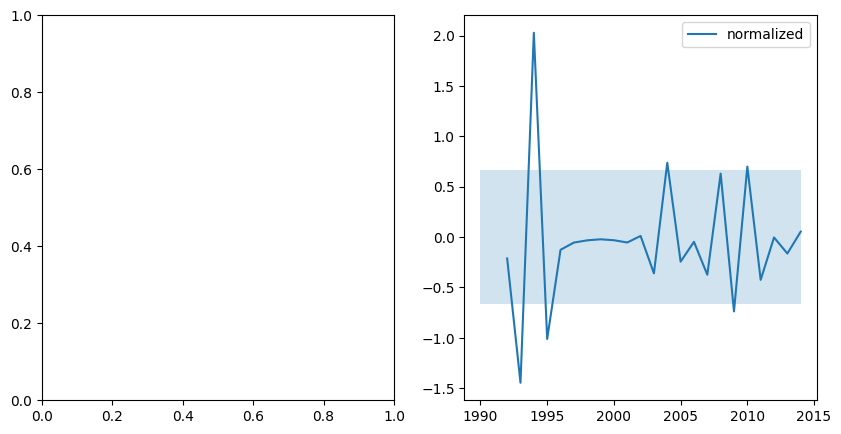

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bnormalized = (cnormalized * 1600).iloc[:-5]
# ax1.plot(bnormalized, label="normalized")
# cstd = bnormalized.std()
# ax1.fill_between(bnormalized.index, -cstd, cstd, alpha=0.2)

ax2.plot(normalized.iloc[:-5], label="normalized")
std = normalized.iloc[:-5].std()
ax2.fill_between(normalized.iloc[:-5].index, -std, std, alpha=0.2)

plt.legend()
plt.show()